[View in Colaboratory](https://colab.research.google.com/github/Mathis1993/Leaf-Classification-CNN/blob/master/Complete_Workflow.ipynb)

# Plant Species Classification using a CNN

<img src="files/180_field_images.jpg">

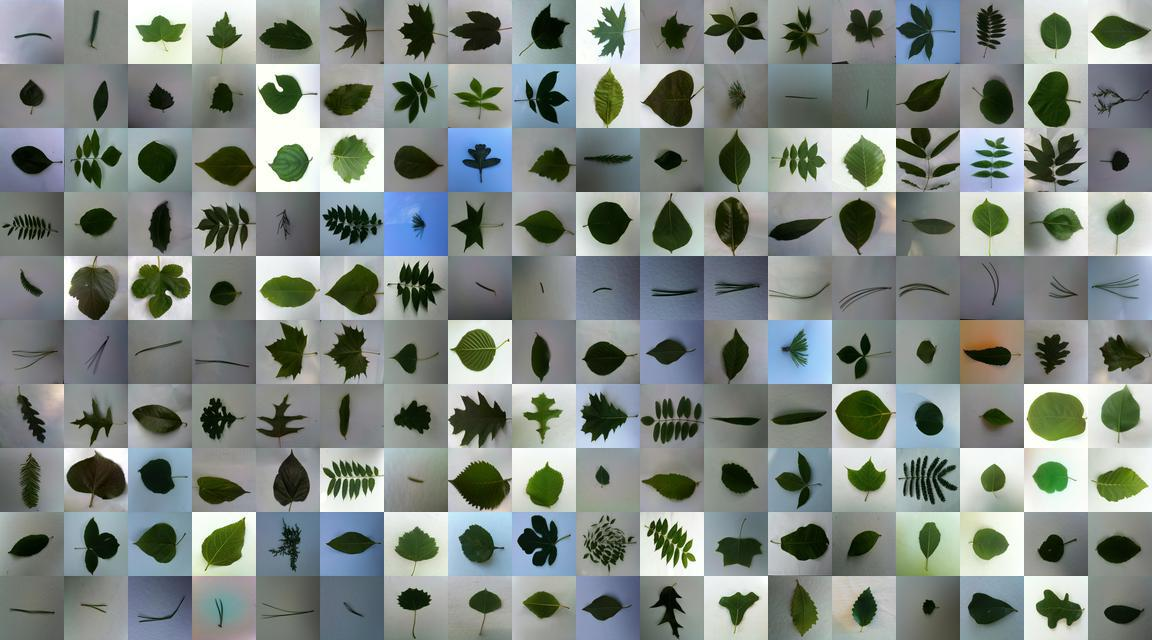

In [4]:
from IPython.display import Image
Image('180_field_images.jpg')

## Introduction

In the course of learning about AI at [TechLabs](https://tech-labs.de/), we realized a small project to classify plant species using a Convolutional Neural Network (CNN).

In 2012, Neeraj Kumar et al. developed [Leafsnap: A Computer Vision System for Automatic Plant Species Identification](https://neerajkumar.org/base/papers/nk_eccv2012_leafsnap.pdf), a mobile app that identifies all 185 tree species in the Northeastern United States using pictures of their leaves. The classification process is based on a computer vision sytem. This system segments the leaf from its background, extracts curvature features of the leaf's contour and classifies it against a dataset containing examples of all the 185 tree species. With this procedure, a top-1 score of about 72% is achieved (meaning that in 72% of cases, the tree species class the computer vision systems assigns the highest probability to is the correct one). 

Examples of 180 of the 185 different plant species can be examined in the image above.

Using this same dataset, that the authors of the paper make available [here](leafsnap.com/dataset/), we asked ourselves if we could possibly beat the traditional computer vision system's performance by implementing the classification task via a CNN. To maximize our learning success, we did not use a pretrained CNN, but built our own network architecture.

In this post, we want to give a full overview of all the steps we took to train our CNN to classify Northeastern American tree species.

Due to limited computational resources on our private hardware, we used [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb), Google's free cloud service for developing deep Iearning applications on a GPU. We will show the necessary steps for getting ready to work, a detailed tutorial is available on [medium](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d).

## Google Colaboratory

In order to use Google Colaboratory, we worked in a IPython Notebook located in a Google Drive storage. 

**Important**: To use the free GPU, go to "Edit-->Notebook Settings" and select "GPU" as hardware accelerator. 

Once connected, Drive can be mounted to Google Colab so that files stored in Drive will be available using the code snippet below.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Then, we can navigate to the desired directory...

In [9]:
%cd /content/drive/My Drive/Colab Notebooks/CNN-Model-files

/content/drive/My Drive/Colab Notebooks/CNN-Model-files


... and start working.

## Preprocessing

Consisting of the following steps:
1. Import packages
2. Read data frame with information about pictures
3. Create numeric labels
4. Resize Pictures 
6. Read pictures as RGB arrays
7. Randomize picture order
8. Stack picture input into one array
9. Normalize input features (pictures) and one-hot encode labels

### 1. Import packages

As a first step, we import the packages necessary for preprocessing the data. 

In [0]:
import os
import PIL
#from PIL import ImageOps
import imageio
import pandas as pd
import numpy as np
import random
import math
import keras

### 2. Read data frame with information about pictures

In the dataset, there is a data frame containing information about the pictures. Relevant for us are the columns:
- path: path to the individual pictures
- species: latin term for each plant
- source: picture taken in lab or field

In [15]:
img_info = pd.read_csv("./leafsnap-dataset-images.txt", sep="\t")
#img_info = pd.read_csv("./Dataset/leafsnap-dataset-images.txt", sep="\t")
img_info.head()

,file_id,image_path,segmented_path,species,source
0,55497,dataset/images/lab/abies_concolor/ny1157-01-1.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab
1,55498,dataset/images/lab/abies_concolor/ny1157-01-2.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab
2,55499,dataset/images/lab/abies_concolor/ny1157-01-3.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab
3,55500,dataset/images/lab/abies_concolor/ny1157-01-4.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab
4,55501,dataset/images/lab/abies_concolor/ny1157-02-1.jpg,dataset/segmented/lab/abies_concolor/ny1157-02...,Abies concolor,lab


We create a new column only holding the filenames and not the whole path to each picture, so that we can assess the filenames for later resizing of the pictures.

In [0]:
img_info["filename"] = None
index_filename = img_info.columns.get_loc("filename")
for i in range(len(img_info)):
    img_info.iloc[i, index_filename] = os.path.basename(str(img_info["image_path"][i]))

### 3. Create numeric labels

Then, we want to have numeric labels instead of the latin term for each plant, so we append another column holding these.
- In the data frame, all images of one species are listed consecutively (first the lab images, then the field images)
- Therefore we just loop over the dataframe and increment the numeric label whenever we encounter a latin term that differs from the previous one

In [17]:
#new column (empty)
img_info["labels_integer"] = None
#index of new column
index_labels_integer = img_info.columns.get_loc("labels_integer")
#index of species column
index_species = img_info.columns.get_loc("species")
#to assign numeric labels starting with 0 for the first species
k = 0 
for i in range(len(img_info)):
    if i == 0:
        img_info.iloc[i, index_labels_integer] = k #here, k == 0
    if i > 0:
        if img_info.iloc[i-1, index_species] == img_info.iloc[i, index_species]:
            img_info.iloc[i, index_labels_integer] = k
        else:
            k += 1
            img_info.iloc[i, index_labels_integer] = k
img_info.tail()

,file_id,image_path,segmented_path,species,source,filename,labels_integer
0,55497,dataset/images/lab/abies_concolor/ny1157-01-1.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab,ny1157-01-1.jpg,0
1,55498,dataset/images/lab/abies_concolor/ny1157-01-2.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab,ny1157-01-2.jpg,0
2,55499,dataset/images/lab/abies_concolor/ny1157-01-3.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab,ny1157-01-3.jpg,0
3,55500,dataset/images/lab/abies_concolor/ny1157-01-4.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab,ny1157-01-4.jpg,0
4,55501,dataset/images/lab/abies_concolor/ny1157-02-1.jpg,dataset/segmented/lab/abies_concolor/ny1157-02...,Abies concolor,lab,ny1157-02-1.jpg,0


### 4. Resize pictures

Next on the list: Resizing the pictures. This is done by reading the filenames from the data frame, generating a cropped version of the desired size for each picture and saving them to an output directory.

In [0]:
def resizeImage(infile, infile_name_only, output_dir="", size=(1024,768)):
  '''
  Resize Images to a requestet size (not considerinng aspect ratio)
  Input:
  - infile: image to be resized (with path)
  - infile_name_only: image to be resized (filename only)
  - output_dir: where resized images should be stored
  - size: output size (tupel of (height, width))
  '''
  
  outfile = os.path.splitext(infile_name_only)[0]
  extension = os.path.splitext(infile)[1]

  if infile != outfile:
    try :
      im = PIL.Image.open(infile)
      #crops to requested size independt from aspec ratio
      im = im.resize(size, PIL.Image.ANTIALIAS) 
      im.save(output_dir + "/" + outfile + extension)
    except IOError:
      print("cannot reduce image for ", infile)

output_dir = "./Dataset/resized"
size = (256, 256)
filenames_dir = list(img_info["image_path"])
filenames = list(img_info["filename"])
            
#for i in range(len(filenames)):
#    resizeImage(filenames_dir[i], filenames[i], output_dir=output_dir, size=size)

### 5. Read pictures as RGB arrays

RGB arrays: All resized images are read as rgb arrays in the order they are listed in the data frame. An RGB array is a numeric representation of a picture, assigning three color values (one for each of the three channels: red, green and blue) to each pixel. From a 64x64 picture, we therefore get a 64x64x3 rgb array.


In [0]:
list_vectors = []

for i in range(len(img_info_red)):
    #path to resized images
    file = "C:\\Users\Mathis\\sciebo\\Machine Learning\\Projekt TechLabs\\Dataset\\resized" + "\\" + img_info_red.iloc[i, index_filename]
    #read as rgb array
    img = imageio.imread(file)
    #append image vector to list
    list_vectors.append(img)

### 6. Randomize picture order

As a next step, we want to randomize the order in which the picture data is fed to the CNN to prevent sequence effects, as the data frame comes ordered by species.

In [0]:
#relevant variables
label = img_info_red["species"]
source = img_info_red["source"]
label_numeric = img_info_red["labels_integer"]
list_vectors = list_vectors
filename = img_info_red["filename"]

#randomization
allinfo = list(zip(label, source, label_numeric, list_vectors, filename)) 
random.shuffle(allinfo) #shuffle
label, source, label_numeric, list_vectors, filename = zip(*allinfo) #decompose again
img_info_rand = pd.DataFrame({"filename":filename, "label":label, "source":source, "label_numeric":label_numeric}) #store picture information in randomized order

### 7. Stack picture input into one array

Now, the picture vectors should be stacked vertically into one array, so that each row represents one picture. This array's shape should then be (30866, 64, 64, 3), as we have 30866 pictures, represented in a 64x64x3 array each. 

In [0]:
X = np.stack((list_vectors))

#transform numeric labels into array
Y = np.asarray(label_numeric)

print(X.shape)

### 8. Normalize input features (pictures) and one-hot encode labels

Finally, we normalize the picture data (dividing by 255, as there are 255 conditions possible for each rgb channel) and one-hot encode the numeric labels. One-hot encoding means to go from a representation where each numeric label is just one number (eg 14 for the 14th of 185 classes, so that we have a vector with 30866 entries for our 30866 pictures), to a representation where in a array each column represents a class and each row a picture. Here, picture number n being of class 14 is represented in the nth row, and only the 14th column contains a one, while all others hold zeros.

In [0]:
X = X/255
Y_one_hot = keras.utils.to_categorical(Y, num_classes=185)
print(Y.shape, Y_one_hot.shape)

We can save the input features, labels, and the further information about the pictures (in the randomized order) so that we don't have to repeat all the above steps in the next session.

In [0]:
np.savez("x_images_arrays", X)
np.savez("y_numeric_labels", Y_one_hot)
img_info_rand.to_csv("img_info_rand_field.csv", index=False)

## CNN-Model

In order to train a CNN on our dataset, we take the following steps:
1. Import packages
2. Split data in train-/development-/test-set
3. Define the model architecture and compile the model
4. Fit the data

### 1. Import packages

First, we import the necessary packages.

In [25]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras import regularizers

Using TensorFlow backend.


### 2. Split data in train-/development-/test-set

Next, we split our picture arrays (and the corresponding labels) into three parts:
1. train-set: The data we train the model on (here 80%)
2. development-set (dev-set): The data we use to evaluate the model's generalization performance (to new, unseen data) during training (here 10%)
3. test-set: The data we want to predict using our trained model (here 10%)
  - For further evaluation of results, we isolate labels (latin terms), numeric labels, filenames and source (lab/field) for the test-set

In [0]:
split_train = 0.8 #train 0.8, validate 0.1, test 0.1
split_val = 0.9
index_train = int(split_train*len(X))
index_val = int(split_val*len(X))

X_train = X[:index_train]
X_val = X[index_train:index_val]
X_test = X[index_val:]

Y_train = Y[:index_train]
Y_val = Y[index_train:index_val]
Y_test = Y[index_val:]

#for later predictions on test set
labels_numeric_test = info.loc[index_val:len(X), "label_numeric"]
labels_test = info.loc[index_val:len(X), "label"]
filenames_test = info.loc[index_val:len(X), "filename"]
source_test = info.loc[index_val:len(X), "source"]

print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

### 3. Define the model architecture and compile the model

For our model, we used the following architecture:
1. Convolutional layer with Batch-Normalization and ReLU-Actiavtion
  - filter size (5,5), 32 filters, no padding, stride (1,1)
  - input: (64,64,3) / output: (60,60,32)
2. Pooling layer
  - pooling size (2,2), 

### 4. Fit the data